In [1]:
import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Dropout, Input, BatchNormalization, concatenate
from keras.models import Model, Sequential
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam,SGD
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import cv2
import tensorflow as tf
import imgaug as ia
import imgaug.augmenters as iaa
from albumentations import (
    RandomRotate90,Flip
)
import scipy.io
import difflib
from scipy import spatial
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import KFold
from keras.preprocessing.sequence import TimeseriesGenerator
from scipy import spatial

gpus = tf.config.experimental.list_physical_devices('GPU')
print('This should list a GPU: ',tf.test.gpu_device_name())
os.chdir('/home/xx652230/Downloads/')

This should list a GPU:  /device:GPU:0


In [2]:
#final EEG model
num_features=64
modele = Sequential([
    Conv2D(filters=64, kernel_size=5, activation='relu', input_shape=(120, 120, 1)),
    Dropout(0.2),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=32, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=16, kernel_size=5, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])
modele.load_weights("/home/xx652230/deap.hdf5")
for i in range(len(modele.layers)-3):
    modele.layers[i].trainable=False
modele.compile(optimizer='adam', loss='categorical_crossentropy' , metrics=['accuracy'])

In [3]:
#training eeg for emotion rcognition
a=Model(inputs=modele.inputs,outputs=modele.layers[-4].output)
f1=Sequential()
f1.add(a)
f1.add(Dense(256, activation="relu"))
f1.add(Dropout(0.2))
f1.add(Dense(5,activation="softmax"))
for i in range(len(f1.layers)-4):
    f1.layers[i].trainable=False
#f1.load_weights("./results/modele_p30.hdf5") 
f1.compile(optimizer="adam", loss='categorical_crossentropy' , metrics=['accuracy'])

In [11]:
#final face model
num_features = 64
width, height = 48, 48
modelf = Sequential([
        Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1)),  # 1
        Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1)),  # 1
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),  # 2
        Dropout(0.5),

        Conv2D(2 * num_features, kernel_size=(3, 3), activation='relu', padding='same'),  # 3
        BatchNormalization(),
        Conv2D(2 * num_features, kernel_size=(3, 3), activation='relu', padding='same'),  # 4
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),  # 5
        Dropout(0.5),

        Conv2D(2 * 2 * num_features, kernel_size=(3, 3), activation='relu', padding='same'),  # 3
        BatchNormalization(),
        Conv2D(2 * 2 * num_features, kernel_size=(3, 3), activation='relu', padding='same'),  # 4
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),  # 5
        Dropout(0.5),

        Conv2D(2 * 2 * 2 * num_features, kernel_size=(3, 3), activation='relu', padding='same'),  # 6
        BatchNormalization(),
        Conv2D(2 * 2 * 2 * num_features, kernel_size=(3, 3), activation='relu', padding='same'),  # 7
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),  # 8
        Dropout(0.5),

        Flatten(),

        Dense(2 * 2 * 2 * num_features, activation='relu'),  # 9
        Dropout(0.4),
        Dense(2 * 2 * num_features, activation='relu'),  # 10
        Dropout(0.4),
        Dense(2 * num_features, activation='relu'),  # 10
        Dropout(0.5),

        Dense(7, activation='softmax')

])
modelf.load_weights("./model/face/final_model_face.hdf5") 
modelf.compile(optimizer='adam', loss='categorical_crossentropy' , metrics=['accuracy'])


In [18]:
#training face model emotional recognition
b=Model(inputs=modelf.inputs,outputs=modelf.layers[-8].output)
f2=Sequential()
f2.add(b)
f2.add(Dense(256, activation="relu"))
f2.add(Dense(5,activation="softmax"))
for i in range(len(f2.layers)-2):
    f2.layers[i].trainable=False
f2.load_weights("./results/modelf_p30.hdf5") 
f2.compile(optimizer="adam", loss='categorical_crossentropy' , metrics=['accuracy'])

In [30]:
#CNN-concatenated model
a1=Model(inputs=modele.inputs,outputs=modele.layers[-4].output)
b1=Model(inputs=modelf.inputs,outputs=modelf.layers[-8].output)
combined = concatenate([a1.output, b1.output])
z1 = Dense(256, activation="relu")(combined)
z1 = Dense(5, activation="softmax")(z1)
model2 = Model(inputs=[a1.input, b1.input], outputs=z1)
for i in range(len(model2.layers)-3):
    model2.layers[i].trainable=False
model2.load_weights("./results/cnnconcat_p30.hdf5")     
model2.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
# cnn-lstm concatenated model
from keras.layers import TimeDistributed,Reshape
a=Model(inputs=modele.inputs,outputs=modele.layers[-4].output)
video=Input(shape=(None,120,120,1))
video1=Input(shape=(None,48,48,1))
#b=Model(inputs=model_dude.inputs,outputs=model_dude.layers[-8].output)
mod=Sequential()
mod.add(video)
mod.add(TimeDistributed(a))
#mod.add(TimeDistributed(Flatten()))
mod.add(LSTM(128,return_sequences=True))
mod.add(TimeDistributed(Dense(128, activation="relu")))

b=Model(inputs=modelf.inputs,outputs=modelf.layers[-8].output)

#b=Model(inputs=model_dude.inputs,outputs=model_dude.layers[-8].output)
mod1=Sequential()
mod1.add(video1)
mod1.add(TimeDistributed(b))
#mod1.add(TimeDistributed(Flatten()))
mod1.add(LSTM(128,return_sequences=True))
mod1.add(TimeDistributed(Dense(128, activation="relu")))
cont=concatenate([mod.output,mod1.output])
z=TimeDistributed(Dense(128, activation="relu"))(cont)
z =TimeDistributed(Dense(5,activation="softmax"))(z)
model_dope=Model(inputs=[mod.input,mod1.input],outputs=z)
for i in range(len(model_dope.layers)-8):
    model_dope.layers[i].trainable=False
model_dope.load_weights("./results/cnnlstmconcat_p30.hdf5")
model_dope.compile(optimizer="adam", loss='categorical_crossentropy' , metrics=['accuracy'])


In [4]:
def read_csv(path,d1,d2):
    file_read=pd.read_csv(path)
    construct=[]  
    for i in range(len(file_read)):
        construct.append(file_read.loc[i,:])
    if d2!=0:    
        file1=np.reshape(np.array(construct)[39:],(len(construct)-39,d1,d2,1))  
        construct.append(file1)
        return file1
    else:
        file1=np.reshape(np.array(construct)[39:],(len(construct)-39,d1))
        return file1
       

# OPERATION 1: TRAINING WITHOUT CROSS VALIDATION

In [23]:
#loading training set(group of 10 participants)
imps=["eeg","face","quad"]
eeg=[]
face=[]
quad_out=[]
score_out=[]
model_out=[]
for i in imps:
    for j in range(1,4):
       if j!=2: 
        if i=="eeg":
            eeg.append(read_csv("./SortedSamples/first10/"+str(i)+str(j)+"0.csv",120,120))
        elif i=="face":   
            face.append(read_csv("./SortedSamples/first10/"+str(i)+str(j)+"0.csv",48,48))
        elif i=="quad":
            quad_out.append(read_csv("./SortedSamples/first10/"+str(i)+str(j)+"0.csv",5,0))
      


In [24]:
#loading testing set(group of 10 participants)
imps=["eeg","face","quad"]
eeg1=[]
face1=[]
quad_out1=[]
score_out1=[]
model_out1=[]
for i in imps:
    for j in range(2,3):
       #if j!=2: 
        if i=="eeg":
            eeg1.append(read_csv("./redo/"+str(i)+str(j)+"0.csv",120,120))
        elif i=="face":   
            face1.append(read_csv("./redo/"+str(i)+str(j)+"0.csv",48,48))
        elif i=="quad":
            quad_out1.append(read_csv("./redo/"+str(i)+str(j)+"0.csv",5,0))
       


In [25]:
x1_train=np.concatenate([eeg[i] for i in range(len(eeg))])
x2_train=np.concatenate([face[i] for i in range(len(eeg))])
y_train=np.concatenate([quad_out[i] for i in range(len(eeg))])
x1_test=np.concatenate([eeg1[i] for i in range(len(eeg1))])
x2_test=np.concatenate([face1[i] for i in range(len(eeg1))])
y_test=np.concatenate([quad_out1[i] for i in range(len(eeg1))])

[]

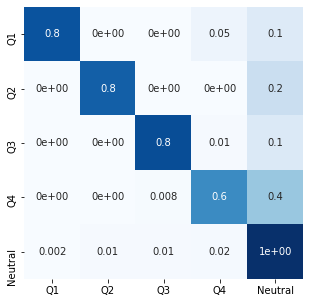

In [37]:
#Model learning
#specify model name from eeg or face 
#f1.fit(np.array(x1_train),np.array(y_train),validation_data=(np.array(x1_test),np.array(y_test)),batch_size=256,epochs=50)
emotion_list = ["Q1","Q2","Q3","Q4","Neutral"]
c1=f2.predict(np.array(x2_test))
c2=np.argmax(c1,axis=1)
y_pred_classes=keras.utils.to_categorical(np.array(c2))
conf_matrix = confusion_matrix(np.argmax(np.array(y_test), axis=1), np.argmax(np.array(y_pred_classes),axis=1), normalize = 'true')
df_conf = pd.DataFrame(conf_matrix, index = [i for i in emotion_list],
                  columns = [i for i in emotion_list])

plt.figure(figsize = (5,5))
sns.heatmap(df_conf, annot=True, cmap = 'Blues', fmt = '.1', cbar = False)
plt.plot()

[]

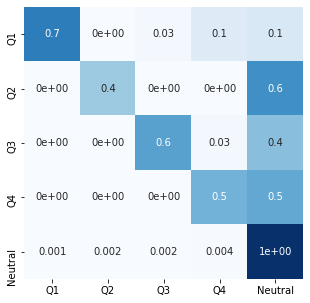

In [36]:
#CNN concatenated Model learning
#model2.fit([np.array(x1_train),np.array(x2_train)],np.array(y_train),validation_data=([np.array(x1_test),np.array(x2_test)],np.array(y_test)),batch_size=256,epochs=50)
emotion_list = ["Q1","Q2","Q3","Q4","Neutral"]
c1=model2.predict([np.array(x1_test),np.array(x2_test)])
c2=np.argmax(c1,axis=1)
y_pred_classes=keras.utils.to_categorical(np.array(c2))
conf_matrix = confusion_matrix(np.argmax(np.array(y_test), axis=1), np.argmax(np.array(y_pred_classes),axis=1), normalize = 'true')
df_conf = pd.DataFrame(conf_matrix, index = [i for i in emotion_list],
                  columns = [i for i in emotion_list])
plt.figure(figsize = (5,5))
sns.heatmap(df_conf, annot=True, cmap = 'Blues', fmt = '.1', cbar = False)
plt.plot()

In [7]:
#for video analysis
def _load_data(data, steps = 40):  
    docX, docY = [], []
    for i in range(0, int(data.shape[0]/steps-1)):
        docX.append(data[i*steps:(i+1)*steps,:])
    return np.array(docX)

In [8]:
xx1=_load_data(np.array(x1_train))
xx2=_load_data(np.array(x2_train))
yy1=_load_data(np.array(y_train))
xx11=_load_data(np.array(x1_test))
xx22=_load_data(np.array(x2_test))
yy11=_load_data(np.array(y_test))

In [ ]:
model_dope.fit([np.array(xx1),np.array(xx2)],np.array(yy1),validation_data=([np.array(xx11),np.array(xx22)],np.array(yy11)),batch_size=256,epochs=50)
emotion_list = ["Q1","Q2","Q3","Q4","Neutral"]
ytest1=[]
ytest2=[]
c1=model_dope.predict([np.array(xx11),np.array(xx22)])
for i in range(len(c1)):
    for j in range(len(c1[i])):
        ytest1.append(yy11[i][j])
        ytest2.append(c1[i][j])

y_pred_classes=np.argmax(ytest2,axis=1)
y_pred_classes = keras.utils.to_categorical(y_pred_classes)
conf_matrix = confusion_matrix(np.argmax(np.array(ytest1), axis=1), np.argmax(np.array(y_pred_classes),axis=1), normalize = 'true')
df_conf = pd.DataFrame(conf_matrix, index = [i for i in emotion_list],
                  columns = [i for i in emotion_list])
plt.figure(figsize = (5,5))
sns.heatmap(df_conf, annot=True, cmap = 'Blues', fmt = '.1', cbar = False)
#plt.savefig("./redo/lstm.jpg")
plt.plot() 

# OPERATION 2: TRAINING WITH CROSS VALIDATION

In [ ]:
#loading each participant for training set
imps=["eeg","face","quad"]
eeg=[]
face=[]
quad_out=[]
score_out=[]
model_out=[]

for j in range(1,31):
    notin=[8,12,28]
    if j not in notin:
      if j<10: 
        for i in imps:
            if i=="eeg":
                eeg.append(read_csv("./SortedSamples/participants/"+str(i)+"P0"+str(j)+".csv",120,120))     
            elif i=="face":   
                face.append(read_csv("./SortedSamples/participants/"+str(i)+"P0"+str(j)+".csv",48,48))
            elif i=="quad":
                quad_out.append(read_csv("./SortedSamples/participants/"+str(i)+"P0"+str(j)+".csv",5,0))
          
      elif  j>9: 
        for i in imps:
            if i=="eeg":
                eeg.append(read_csv("./SortedSamples/participants/"+str(i)+"P"+str(j)+".csv",120,120))      
            elif i=="face":   
                face.append(read_csv("./SortedSamples/participants/"+str(i)+"P"+str(j)+".csv",48,48))
            elif i=="quad":
                quad_out.append(read_csv("./SortedSamples/participants/"+str(i)+"P"+str(j)+".csv",5,0))
           


In [5]:
#loading each participant for testing set
imps=["eeg","face","quad"]
eeg1=[]
face1=[]
quad_out1=[]
score_out1=[]
model_out1=[]
for j in range(1,31):
    notin=[8,12,28]
    if j not in notin :
      if j<10: 
        for i in imps:
            if i=="eeg":
                eeg1.append(read_csv("./t/"+str(i)+"P0"+str(j)+".csv",120,120))     
            elif i=="face":   
                face1.append(read_csv("./t/"+str(i)+"P0"+str(j)+".csv",48,48))
            elif i=="quad":
                quad_out1.append(read_csv("./t/"+str(i)+"P0"+str(j)+".csv",5,0))
         
      elif  j>9: 
        for i in imps:
            if i=="eeg":
                eeg1.append(read_csv("./t/"+str(i)+"P"+str(j)+".csv",120,120))              
            elif i=="face":   
                face1.append(read_csv("./t/"+str(i)+"P"+str(j)+".csv",48,48))
            elif i=="quad":
                quad_out1.append(read_csv("./t/"+str(i)+"P"+str(j)+".csv",5,0))
         


In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=None, shuffle=True)
acc_per_fold=[]
loss_per_fold=[]
for train_index,test_index in kf.split(np.array(eeg)):
    x1=np.concatenate([eeg[i] for i in train_index])
    x2=np.concatenate([face[i] for i in train_index])
    y1=np.concatenate([quad_out[i] for i in train_index])
    x4=np.concatenate([eeg1[i] for i in test_index])
    x5=np.concatenate([face1[i] for i in test_index])
    y6=np.concatenate([quad_out1[i] for i in test_index])
    history = model2.fit([np.array(x1),np.array(x2)], np.array(y1), validation_data=([np.array(x4),np.array(x5)], np.array(y6)),epochs=20, verbose=1,batch_size=256)  
    scores = model2.evaluate([np.array(x4),np.array(x5)], np.array(y6), verbose=0)
    print(f'Score for fold : {model2.metrics_names[0]} of {scores[0]}; {model2.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    

In [8]:
def _load_data(data, steps = 40):  
    docX, docY = [], []
    for i in range(0, int(data.shape[0]/steps-1)):
        docX.append(data[i*steps:(i+1)*steps,:])
    return np.array(docX) #np.array(docY)

In [ ]:
#5 fold cross validation cnn concate
import numpy as np
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=True)
acc_per_fold=[]
loss_per_fold=[]
for train_index, test_index in kf.split(np.array(x1)):
    X_train, X_test = [np.array(x1)[train_index], np.array(x2)[train_index]],[np.array(x1)[test_index],np.array(x2)[test_index]]
    y_train, y_test = np.array(y1)[train_index], np.array(y1)[test_index]
    history = model2.fit([X_train[0],X_train[1]], y_train, validation_data=([X_test[0],X_test[1]], y_test),epochs=15, verbose=1,batch_size=256)  
    scores = model2.evaluate([X_test[0],X_test[1]], y_test, verbose=0)
    print(f'Score for fold : {model2.metrics_names[0]} of {scores[0]}; {model2.metrics_names[1]} of {scores[1]*100}%')   
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

In [ ]:
#5 fold cross validation cnn-lstm concate
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=None, shuffle=True)
acc_per_fold=[]
loss_per_fold=[]
matrix=[]
for train_index,test_index in kf.split(np.array(eeg)):
    print(train_index,test_index)
    emotion_list=["Q1","Q2","Q3","Q4","Neutral"]
    x1=np.concatenate([eeg[i] for i in train_index])  
    x2=np.concatenate([face[i] for i in train_index])
    y1=np.concatenate([quad_out[i] for i in train_index])
    x4=np.concatenate([eeg1[i] for i in test_index])
    x5=np.concatenate([face1[i] for i in test_index])
    y6=np.concatenate([quad_out1[i] for i in test_index])
    xx1=_load_data(np.array(x1))
    xx2=_load_data(np.array(x2))
    yy1=_load_data(np.array(y1))
    xx4=_load_data(np.array(x4))
    xx5=_load_data(np.array(x5))
    yy6=_load_data(np.array(y6))
    history = model_dope.fit([np.array(xx1),np.array(xx2)], np.array(yy1), validation_data=([np.array(xx4),np.array(xx5)], np.array(yy6)),epochs=10, verbose=1,steps_per_epoch=10)  
    scores = model_dope.evaluate([np.array(xx4),np.array(xx5)], np.array(yy6), verbose=0)          
    print(f'Score for fold : {model_dope.metrics_names[0]} of {scores[0]}; {model_dope.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])